# Многослойные сети. Алгоритм обратного распространения ошибки.

Импорт необходимых библиотек.

In [1]:
import numpy as np
import pandas as pd
import math as mh
import seaborn as sb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend
from keras.models import load_model

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,10)
from mpl_toolkits.mplot3d import Axes3D

# I. Многослойная нейронная сеть для классификации точек в случае, когда классы не являются линейно разделимыми.

Заданы 3 линейно неразделимых класса. Точки, принадлежащие одному классу, лежат на алгебраической линии. Необходимо обучить сеть для классификации точек в заданной области.
В моем варианте все три класса представлены эллипсами, соответсвенно, сгенерируем множество точек для каждого эллипса.

In [2]:
class Ellipse(object):
    def __init__(self, a, b, alpha = 0, x0 = 0, y0 = 0):
        self.a = a
        self.b = b
        self.alpha = alpha
        self.x0 = x0
        self.y0 = y0
        self.x, self.y = np.array([]), np.array([])
        self.dim = 0
        
    def f(self, t):
        x = self.a * np.cos(t)
        y = self.b * np.sin(t)
        return x * mh.cos(self.alpha) + y * mh.sin(self.alpha) - self.x0
    
    def g(self, t):
        x = self.a * np.cos(t)
        y = self.b * np.sin(t)
        return - x * mh.sin(self.alpha) + y * mh.cos(self.alpha) - self.y0

    def points_gen(self, start, stop, step):
        t = np.arange(start, stop, step)
        self.x = self.f(t)
        self.y = self.g(t)
        self.dim = np.size(t)

    def show(self, color='blue'):
        print("Эллипс построен!")
        
        plt.plot(self.x, self.y, color=color)
        plt.title('Эллипс')
        plt.ylabel('x')
        plt.xlabel('y')
        plt.grid()
        plt.show()

Зададим параметры для генерации точек.

In [3]:
start = 0
step = 0.025
stop = 2 * mh.pi

Создадим три эллипса согласно варианту и сгенерируем для них точки.

Эллипс построен!


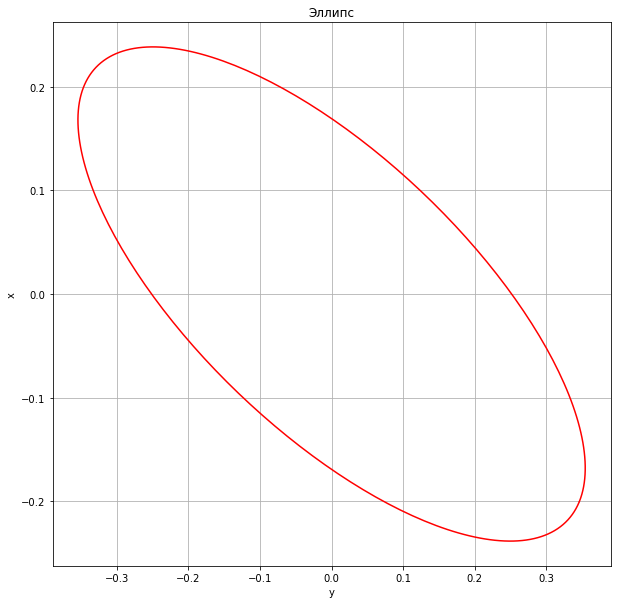

In [4]:
a, b, alpha = 0.4, 0.15, mh.pi/ 6
line1 = Ellipse(a, b, alpha)
line1.points_gen(start, stop, step)
line1.show('red')

Эллипс построен!


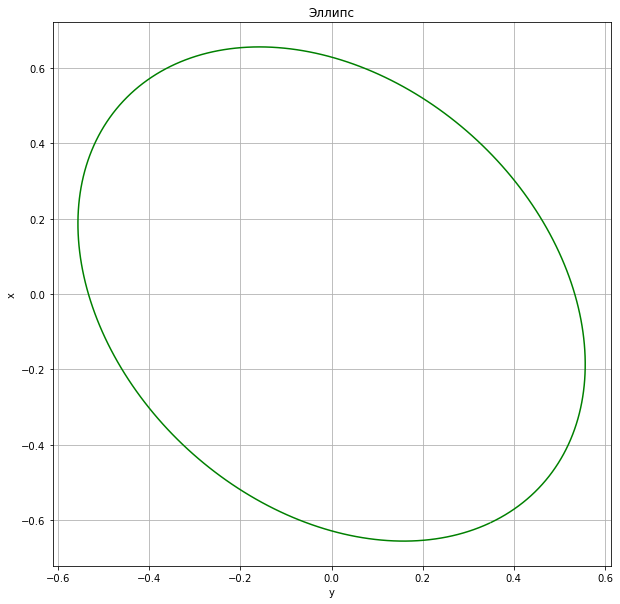

In [5]:
a, b, alpha = 0.7, 0.5, mh.pi/ 3
line2 = Ellipse(a, b, alpha)
line2.points_gen(start, stop, step)
line2.show('green')

Эллипс построен!


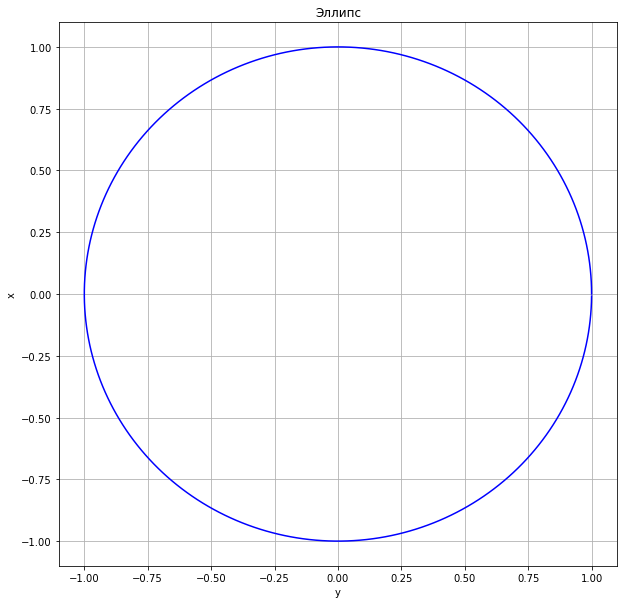

In [6]:
a, b = 1, 1
line3 = Ellipse(a, b)
line3.points_gen(start, stop, step)
line3.show('blue')

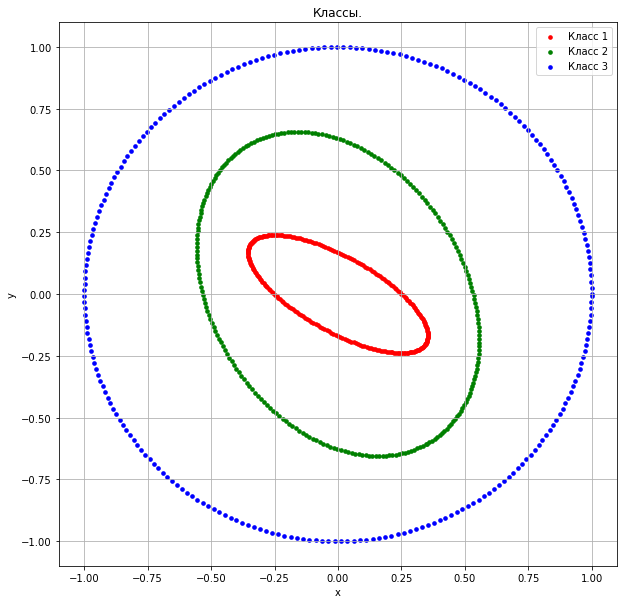

In [7]:
plt.scatter(line1.x, line1.y, color='r', linewidth=2, s=7)
plt.scatter(line2.x, line2.y, color='g', linewidth=2, s=7)
plt.scatter(line3.x, line3.y, color='b', linewidth=2, s=7)


plt.title('Классы.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1', 'Класс 2', 'Класс 3'], loc='upper right')
plt.grid()
plt.show()

# Работа с данными

Для формирования обучающей выборки выберем из первого класса 60 точек рандомным образом,из второго и третьего классов - 100 и 120 точек соответственно.

In [8]:
r = np.array([[line1.x[i], line1.y[i]] for i in np.random.permutation(line1.dim)[:100]])
g = np.array([[line2.x[i], line2.y[i]] for i in np.random.permutation(line2.dim)[:100]])
b = np.array([[line3.x[i], line3.y[i]] for i in np.random.permutation(line3.dim)[:120]])

Теперь разделим множества точек каждого класса на обучающее, контрольное и тестовое подмножества в соотношении 70 : 20 : 10.Чтобы модель обучалась на разнородных данных, сначала перемешаем полученные точки.

In [9]:
np.random.shuffle(r)
np.random.shuffle(g)
np.random.shuffle(b)

r_train, r_val, r_test = np.array_split(r, [ int( 0.7 * np.shape(r)[0]), int( 0.9 * np.shape(r)[0])])
g_train, g_val, g_test = np.array_split(g, [ int( 0.7 * np.shape(g)[0]), int( 0.9 * np.shape(g)[0])])
b_train, b_val, b_test = np.array_split(b, [ int( 0.7 * np.shape(b)[0]), int( 0.9 * np.shape(b)[0])])

Отобразим полученные выборки для каждого класса.

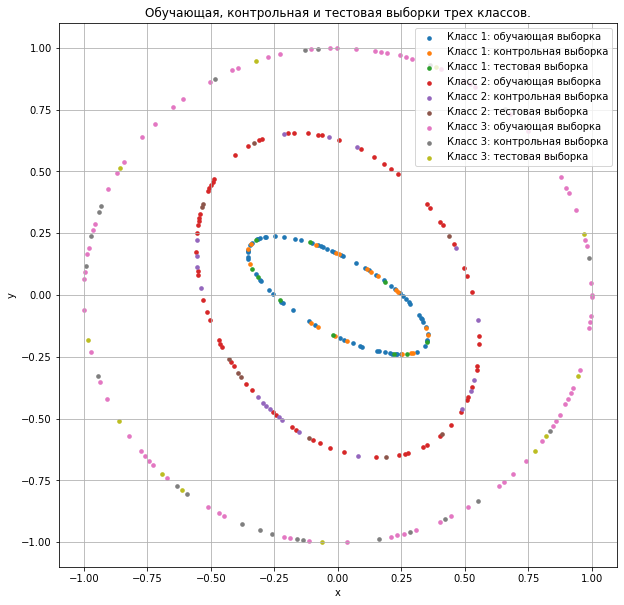

In [10]:
plt.scatter(r_train[:,0], r_train[:,1], linewidth=2, s=7)
plt.scatter(r_val[:,0], r_val[:,1], linewidth=2, s=7)
plt.scatter(r_test[:,0], r_test[:,1], linewidth=2, s=7)

plt.scatter(g_train[:,0], g_train[:,1], linewidth=2, s=7)
plt.scatter(g_val[:,0], g_val[:,1], linewidth=2, s=7)
plt.scatter(g_test[:,0], g_test[:,1], linewidth=2, s=7)

plt.scatter(b_train[:,0], b_train[:,1], linewidth=2, s=7)
plt.scatter(b_val[:,0], b_val[:,1], linewidth=2, s=7)
plt.scatter(b_test[:,0], b_test[:,1], linewidth=2, s=7)

plt.title('Обучающая, контрольная и тестовая выборки трех классов.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1: обучающая выборка ', 'Класс 1: контрольная выборка', 'Класс 1: тестовая выборка',
           'Класс 2: обучающая выборка ', 'Класс 2: контрольная выборка', 'Класс 2: тестовая выборка',
           'Класс 3: обучающая выборка ', 'Класс 3: контрольная выборка', 'Класс 3: тестовая выборка'], loc='upper right')
plt.grid()
plt.show()

Согласно построенному изображению, классы не пересекаются, т.е. нет точек, принадлежащих одному и тому же классу.

Теперь, когда подмножества для всех классов сформированы, сгенерируем выходные значения для каждой точки каждого класса. Далее, объединим полученные входные и выходные выборки в три общие выборки - тренировочное, валидационное даннные и тестовое подмножества.

Генерация входов и выходов сети множества тренировочных точек.

In [11]:
def data_gen(r, g, b):
    #train_X, train_Y = np.empty((0,2)), np.empty((0,3))
    X, Y = [], []
    classes = np.vstack((r, g, b))
    np.random.shuffle(classes)

    for i in classes:
        j = list(i)
        
        if j in X:
            continue
        #t = np.zeros(3)
        t = [0, 0, 0]
        if i in r:
            t[0] += 1
        if i in g:
            t[1] += 1
        if i in b:
            t[2] += 1
        #train_X = np.append(train_X, [i], axis=0)
        X.append(j)
        #train_Y = np.append(train_Y, [t], axis=0)
        Y.append(t)
    return np.array(X), np.array(Y)

Формирование обучающей, валидационной и тестовой выборок.

In [12]:
train_X, train_Y = data_gen(r_train, g_train, b_train)
val_X, val_Y = data_gen(r_val, g_val, b_val)
test_X, test_Y = data_gen(r_test, g_test, b_test)

# Конструирование и обучение сети

В данной лабораторной работе я решила воспользоваться библиотекой keras для проектирования многослойной сети.

Сеть будет состоять из двух полносвязных слоев. Скрытый слой будет состоять из 20 нейронов, а выходной слой из трех. В качестве функции активации для скрытого и выходного слоя я гипербалический тангенс. 

In [13]:
print("Конструирование сети")

net = Sequential()
net.add(Dense(20, activation = 'tanh', input_dim = 2))
net.add(Dense(3, activation = 'tanh'))

Конструирование сети


В качестве алгоритма обучения я задаю метод стахостического градиентного спуска с коэффициентом обучения, равным 0.05. В качестве функции ошибки, которая минимизируется в процессе обучения, я задаю mse - среднеквадратичную функцию ошибки.

In [14]:
print("Конфигурация сети")
learning_rate = 0.05
net.compile(optimizer = tf.keras.optimizers.SGD(lr = learning_rate, decay = 1e-5),
              loss ='mse',
              metrics=['mae'])
net.summary()

Конфигурация сети
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


Зададим параметры обучения: число эпох обучения и число эпох,
в течение которых может расти ошибка на контрольном подмножестве, равными 1500 и 500 соответственно.

In [15]:
print('Обучение модели на обучающей и проверочной выборках')

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 1e-4,
        patience = 500,
        )]
history = net.fit(train_X, train_Y,
                    batch_size = 1,
                    epochs = 1500,
                    verbose = 2,
                    callbacks = callbacks,
                    validation_data=(val_X, val_Y))

Обучение модели на обучающей и проверочной выборках
Epoch 1/1500
224/224 - 0s - loss: 0.2422 - mae: 0.4453 - val_loss: 0.2334 - val_mae: 0.4510
Epoch 2/1500
224/224 - 0s - loss: 0.2274 - mae: 0.4387 - val_loss: 0.2381 - val_mae: 0.4498
Epoch 3/1500
224/224 - 0s - loss: 0.2277 - mae: 0.4414 - val_loss: 0.2440 - val_mae: 0.4452
Epoch 4/1500
224/224 - 0s - loss: 0.2284 - mae: 0.4410 - val_loss: 0.2259 - val_mae: 0.4467
Epoch 5/1500
224/224 - 0s - loss: 0.2267 - mae: 0.4413 - val_loss: 0.2281 - val_mae: 0.4340
Epoch 6/1500
224/224 - 0s - loss: 0.2212 - mae: 0.4320 - val_loss: 0.2249 - val_mae: 0.4479
Epoch 7/1500
224/224 - 0s - loss: 0.2222 - mae: 0.4368 - val_loss: 0.2149 - val_mae: 0.4323
Epoch 8/1500
224/224 - 0s - loss: 0.2189 - mae: 0.4328 - val_loss: 0.2165 - val_mae: 0.4368
Epoch 9/1500
224/224 - 0s - loss: 0.2148 - mae: 0.4283 - val_loss: 0.2033 - val_mae: 0.4230
Epoch 10/1500
224/224 - 0s - loss: 0.2035 - mae: 0.4125 - val_loss: 0.2019 - val_mae: 0.4122
Epoch 11/1500
224/224 - 0s 

Посмотрим, как изменялась величина ошибки в процессе обучения.

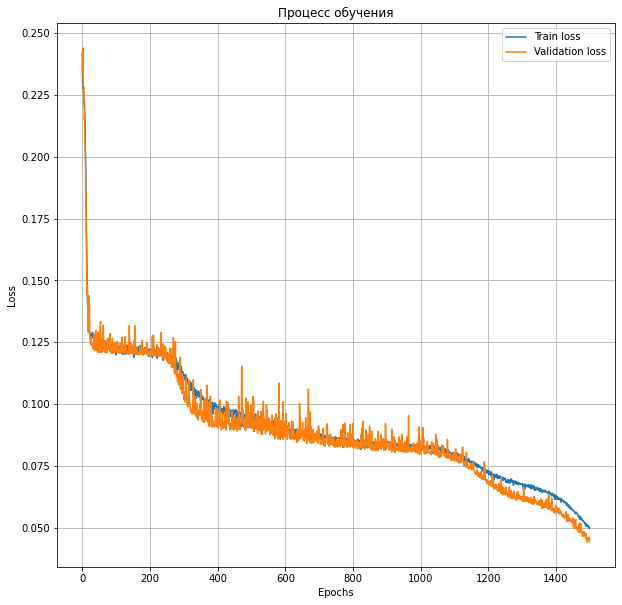

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Процесс обучения')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.grid()
plt.show()

# Тестирование сети и обработка результатов

Будем преобразовывать выходные значения сети согласно правилу.

In [17]:
def transform(preds):
    for i in range(np.shape(preds)[0]):
        for j in range(3):
            if preds[(i, j)] >= 0.5:
                preds[(i, j)] = 1
            else:
                preds[(i, j)] = 0
    return preds

In [18]:
def check(preds, true):
    correct = 0
    dim = np.shape(preds)[0]
    for p, t in zip(preds, true):
        if np.array_equal(p, t):
            correct += 1
    print("Сеть правильно классифицировала ", correct, " точек из ", dim)
    print("Точность обучения: ", round(correct/ dim * 100, 2), " %")

Протестируем модель на всех трех выборках. Результаты классификации на обучающей выборке.

In [19]:
preds = net(train_X)
p = transform(preds.numpy())
check(p, train_Y)

Сеть правильно классифицировала  206  точек из  224
Точность обучения:  91.96  %


Результаты классификации на валидационной выборке.

In [20]:
preds = net(val_X)
p = transform(preds.numpy())
check(p, val_Y)

Сеть правильно классифицировала  60  точек из  64
Точность обучения:  93.75  %


Результаты классификации на тестовой выборке.

In [21]:
preds = net(test_X)
p = transform(preds.numpy())
check(p, test_Y)

Сеть правильно классифицировала  30  точек из  32
Точность обучения:  93.75  %


# Классификация точек сетки

Теперь, когда мы проверили качество обучения сети на всех трех выборках, будем классифицировать все точки области $[-1.2; 1.2]x[-1.2; 1.2].$

Генерация всех точек сетки заданной области.

In [22]:
image = np.empty((0, 2))
n = np.arange(-1.1, 1.1, 0.025)
for i in n:
    for j in n:
        image = np.vstack((image, np.array([i, j])))

Классификация точек сетки. Округлим выходные значения сети, создадим по ним матрицу $MxNx3$ и построим по ней цветовую карту.

In [23]:
preds = net(image)
p = np.round(preds.numpy(), 1)

dimp = int(np.shape(p)[0] ** 0.5)
matrix = np.array( [ [ p[j * dimp + i] for i in range(dimp) ] for j in range(dimp) ])

Построим цветовую карту.

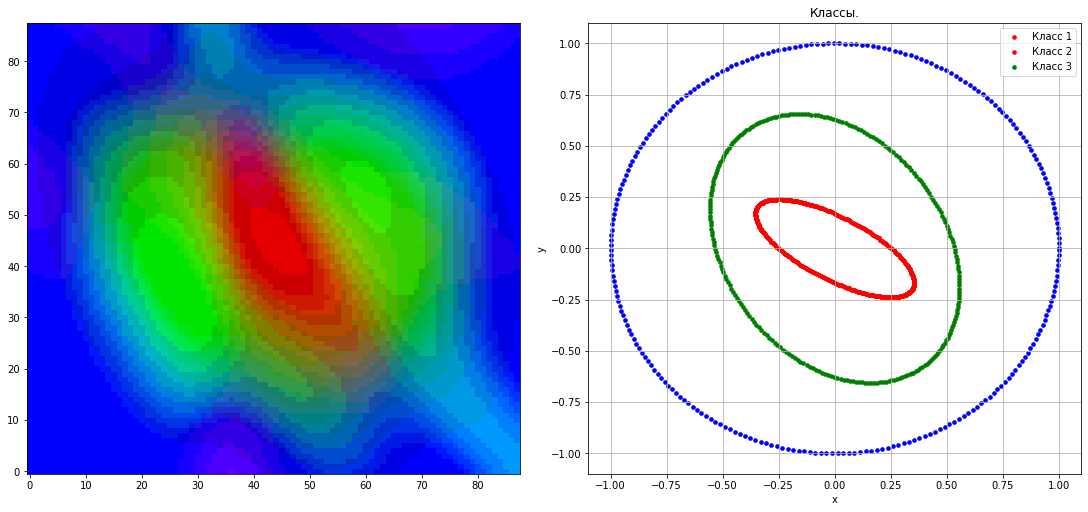

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
p1 = axes[0].imshow(matrix, aspect='auto', origin="lower")

plt.scatter(line1.x, line1.y, color='r', linewidth=2, s=7), 
plt.scatter(line1.x, line1.y, color='r', linewidth=2, s=7)
plt.scatter(line2.x, line2.y, color='g', linewidth=2, s=7)
plt.scatter(line3.x, line3.y, color='b', linewidth=2, s=7)


plt.title('Классы.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1', 'Класс 2', 'Класс 3'], loc='upper right')
plt.grid()
plt.show()

# II. Многослойная нейронная сеть для аппроксимации функции. Обучение с помощью одного из методов первого порядка.


Будем решать задачу аппроксимации заданной функции. Для этого построим и обучим двухслойную нейронную сеть прямого распространения. В качестве метода обучения, будем использовать методы первого и второго порядков.

Определим функцию, которую будем аппроксимировать.

In [25]:
def x(t):
    return np.cos(2.5 * t**2 - 5 * t)

Сформируем обучающую выборку.

In [26]:
a, b, h = 0, 2.2, 0.01
T = np.arange(a, b, h)
X = x(T)

Разделим обучающую выборку на обучающее и контрольное подможество. В качестве контрольного подмножества возьмем 10% с конца временного ряда.

In [27]:
train_T, val_T =  np.array_split(T, [ int( 0.9 * np.shape(T)[0])])
train_X, val_X =  np.array_split(X, [ int( 0.9 * np.shape(X)[0])])

Визуализируем выборки.

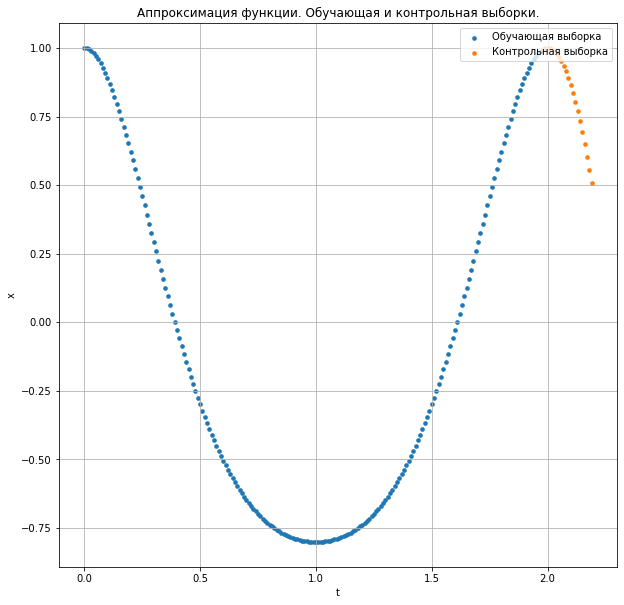

In [28]:
plt.scatter(train_T, train_X, linewidth=2, s=7)
plt.scatter(val_T, val_X, linewidth=2, s=7)

plt.title('Аппроксимация функции. Обучающая и контрольная выборки.')
plt.ylabel('x')
plt.xlabel('t')
plt.legend(['Обучающая выборка', 'Контрольная выборка'], loc='upper right')
plt.grid()
plt.show()

# Конструирование и обучение сети

Сеть будет состоять из двух полносвязных слоев. Скрытый слой будет состоять из 10 нейронов, а выходной слой из одного. В качестве функции активации для скрытого слоя будем использовать гиперболический тангенс, а для выходного слоя - линейную функцию.

In [29]:
print("Конструирование сети")

model = Sequential()
model.add(Dense(15, activation = 'tanh', input_dim = 1))
model.add(Dense(1, activation = 'linear'))

Конструирование сети


В качестве алгоритма обучения я задаю метод гибкого распространения с коэффициентом обучения, равным 0.05. В качестве функции ошибки, которая минимизируется в процессе обучения, я задаю mse - среднекважратичную ошибку.

In [30]:
print("Конфигурация сети")
learning_rate = 0.05
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate),
              loss ='mse',
              metrics=['mae'])
model.summary()

Конфигурация сети
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


Зададим параметры обучения: число эпох обучения и число эпох, в течение которых может расти ошибка на контрольном подмножестве, равными 600.

In [31]:
print('Обучение модели на обучающей и проверочной выборках')
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 1e-4,
        patience = 600,
        )]
history = model.fit(train_T, train_X,
                    batch_size = 1,
                    epochs = 600,
                    verbose = 2,
                    callbacks = callbacks,
                    validation_data=(val_T, val_X))

Обучение модели на обучающей и проверочной выборках
Epoch 1/600
198/198 - 0s - loss: 0.4755 - mae: 0.6011 - val_loss: 1.7200 - val_mae: 1.3023
Epoch 2/600
198/198 - 0s - loss: 0.4214 - mae: 0.5447 - val_loss: 0.5735 - val_mae: 0.7405
Epoch 3/600
198/198 - 0s - loss: 0.2564 - mae: 0.3875 - val_loss: 0.2387 - val_mae: 0.4561
Epoch 4/600
198/198 - 0s - loss: 0.1743 - mae: 0.3094 - val_loss: 0.4190 - val_mae: 0.6114
Epoch 5/600
198/198 - 0s - loss: 0.1244 - mae: 0.2570 - val_loss: 0.1639 - val_mae: 0.3441
Epoch 6/600
198/198 - 0s - loss: 0.1195 - mae: 0.2673 - val_loss: 0.0911 - val_mae: 0.2643
Epoch 7/600
198/198 - 0s - loss: 0.1090 - mae: 0.2599 - val_loss: 0.0588 - val_mae: 0.2096
Epoch 8/600
198/198 - 0s - loss: 0.0895 - mae: 0.2274 - val_loss: 0.4607 - val_mae: 0.6434
Epoch 9/600
198/198 - 0s - loss: 0.0952 - mae: 0.2370 - val_loss: 0.0567 - val_mae: 0.2093
Epoch 10/600
198/198 - 0s - loss: 0.0799 - mae: 0.2205 - val_loss: 0.0863 - val_mae: 0.2195
Epoch 11/600
198/198 - 0s - loss: 0.0

Визуализация процесса обучения.

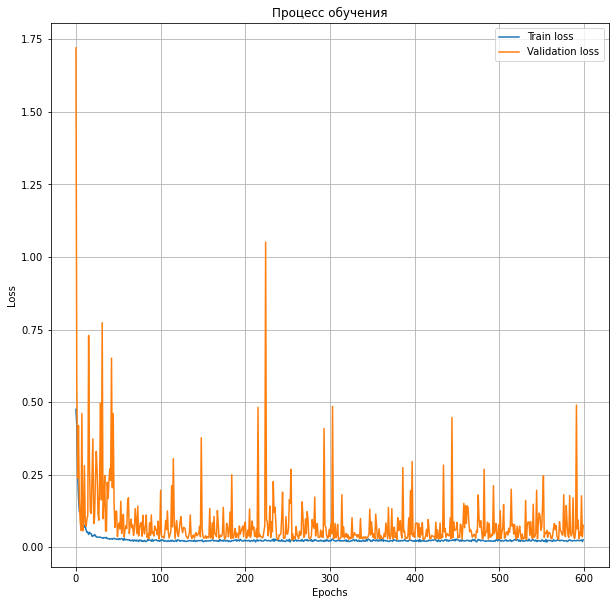

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Процесс обучения')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.grid()
plt.show()

Согласно графику, сеть переобучается. График изменения величины ошибки на валидационном подмножестве скачкообразный, однако на тренировочном подмножестве величина ошибки стремится к нулю. Это означает, что сеть запоминает тренировочные примеры, и при малейшем отклонении данных, выдает некорректные результаты. К сожалению, сконструированная сеть не имеет обобщающей способности.

Чтобы преодолеть переобучение, я меняла число эпох и количество нейронов скрытого слоя, однако, этих мер оказалось недостаточно.

# Тестирование сети и обработка результатов

Рассчитаем показатели качества обучения для обучающего и проверочного подмножеств.

Среднеквадратичная функция ошибки.

In [33]:
def mse(preds, t):
    t.resize((np.shape(t)[0], 1))
    print("MSE: ", mh.sqrt(np.sum((t - preds)**2) / np.shape(t)[0]))

In [34]:
preds = np.array([model(train_T), model(val_T)])
mae = tf.keras.losses.MeanAbsoluteError()
mse(preds[0], train_X)
mse(preds[1], val_X)

print("MAE train: ", mae(train_X, preds[0]).numpy())
print("MAE val: ", mae(val_X, preds[1]).numpy())

MSE:  0.13154630860803182
MSE:  0.2755691471100823
MAE train:  0.11785793
MAE val:  0.21495943


Визуализируем предсказанные и эталонные значения для двух подмножеств.

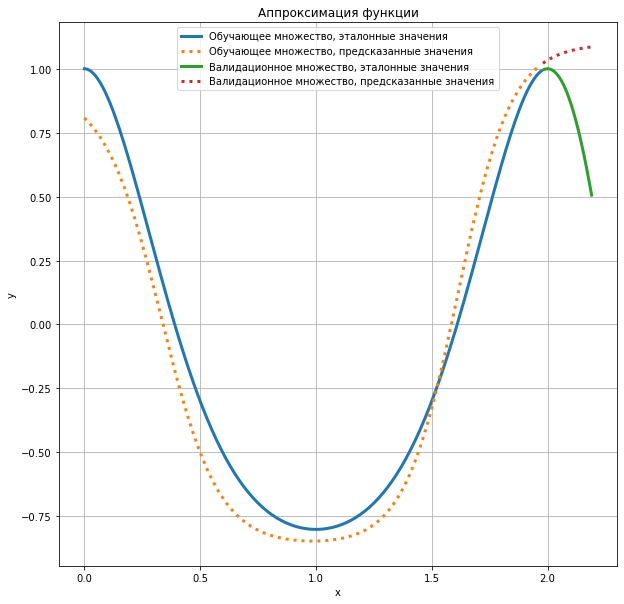

In [35]:
plt.plot(train_T, train_X, linewidth=3)
plt.plot(train_T, preds[0].numpy(), linestyle=':', linewidth=3)

plt.plot(val_T, val_X, linewidth=3)
plt.plot(val_T, preds[1].numpy(), linestyle=':', linewidth=3)

plt.title('Аппроксимация функции')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Обучающее множество, эталонные значения', 'Обучающее множество, предсказанные значения',
            'Валидационное множество, эталонные значения', 'Валидационное множество, предсказанные значения'])
plt.grid()
plt.show()

Как видно из графика, сеть не обучается должным образом - она запоминает тренировочное подмножество, не выводит обобщающее правило. Возможно, методы более высокого порядка оказались бы более действенными.